In [1]:
# These should already be installed on your workspace
!pip install --disable-pip-version-check --quiet -U langchain==0.2.16
!pip install --disable-pip-version-check --quiet -U langchain_openai==0.1.23
!pip install --disable-pip-version-check --quiet -U langgraph==0.2.19
!pip install --disable-pip-version-check --quiet -U langchainhub==0.1.21
!pip install --disable-pip-version-check --quiet -U tavily-python==0.4.0
!pip install --disable-pip-version-check --quiet -U langchain-community==0.2.16
!pip install --disable-pip-version-check --quiet -U python-dotenv==1.0.1

In [2]:
# Load in the OpenAI key and Tavily key.
# In the project folder, create a file named 'config.env'
# ensure your .env file contains keys named OPENAI_API_KEY="your key" and TAVILY_API_KEY="your key"
from dotenv import load_dotenv
import os

load_dotenv()
assert os.getenv('OPENAI_API_KEY') is not None
assert os.getenv('TAVILY_API_KEY') is not None

In [3]:
import time 
from langgraph.graph import MessagesState, START, StateGraph, END
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig
from IPython.display import Image, display
from langchain_tavily import TavilySearch
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from typing import Literal

# Helper functions
def display_text_to_user(text):
    print(text) 
    time.sleep(1) # wait for it to render before asking for input, or it'll never show up.

def ask_user_for_input(input_description):
    response = input(input_description)
    return response
    
class State(MessagesState):
    topic: str
    summary: str
    quiz: str
    quiz_ground_truth: str
    answer: str
    grade: str

model = ChatOpenAI(temperature=0, streaming=True, base_url="https://openai.vocareum.com/v1")
tavily_tool = TavilySearch(max_results=5)
tools = [tavily_tool]
model_with_tools = model.bind_tools(tools)

In [4]:
def ask_for_topic(state: State):
    topic = ask_user_for_input("What health topic or medical condition would you like to learn about? ")
    # Prepare the initial messages for the agent
    messages = [
        SystemMessage(
            content="You are a HealthBot. Your task is to research a given health topic using the available tools and then provide a 3-4 paragraph summary of the results in a patient-friendly way. Do not use any other knowledge or data sources."
        ),
        HumanMessage(content=topic)
    ]
    return {"topic": topic, "messages": messages}

In [5]:
# New agent node that calls the model
def agent(state: State):
    display_text_to_user("Thinking...")
    messages = state['messages']
    response = model_with_tools.invoke(messages)
    return {"messages": state['messages'] + [response]}

In [6]:
def tool_executor(state: State):
    display_text_to_user(f"Searching for information on {state['topic']}...")
    last_message = state['messages'][-1]
    tool_call = last_message.tool_calls[0]
    tool_output = tavily_tool.invoke(tool_call['args'])
    print("---- Tavily ----", tool_output)
    tool_message = ToolMessage(content=str(tool_output), tool_call_id=tool_call['id'])
    return {"messages": state['messages'] + [tool_message]}

In [7]:
def extract_summary(state: State):
    display_text_to_user("Summarizing the information...")
    tool_messages = [msg for msg in state['messages'] if isinstance(msg, ToolMessage)]
    tool_outputs = "\n\n".join([msg.content for msg in tool_messages])
    if not tool_outputs:
        return {"summary": "No information could be found for the given topic."}

    response = model.invoke([HumanMessage(content=f"""Based on the user's question about "{state['topic']}" and the following search results, please provide a 3-4 paragraph summary of these search results in a patient-friendly way. Do not use any other knowledge or data sources.

    Search Results:
    {tool_outputs}
    """)])

    return {"summary": response.content}

In [8]:
def present_summary(state: State):
    display_text_to_user("Here is a summary of the information:")
    display_text_to_user(state['summary'])
    return {}

In [9]:
def prompt_for_quiz(state: State):
    ask_user_for_input("When you are ready for a comprehension check, press Enter.")
    return {}

In [10]:
def generate_quiz(state: State):
    display_text_to_user("Generating a quiz question...")
    response = model.invoke([
        HumanMessage(content=f"Based ONLY on the following summary, create a single multiple-choice quiz question to test understanding. Do not use any external knowledge. Provide the question and the correct answer, separated by '---ANSWER---'.\n\nSummary:\n{state['summary']}")
    ])

    quiz_content = response.content
    parts = quiz_content.split("---ANSWER---")
    question = parts[0].strip()
    ground_truth = parts[1].strip() if len(parts) > 1 else "Could not parse answer."

    return {"quiz": question, "quiz_ground_truth": ground_truth}

In [11]:
def present_quiz(state: State):
    display_text_to_user("Here is your quiz question:")
    display_text_to_user(state['quiz'])
    return {}

In [12]:
def get_quiz_answer(state: State):
    answer = ask_user_for_input("Your answer: ")
    return {"answer": answer}

In [13]:
def grade_quiz(state: State):
    display_text_to_user("Grading your answer...")
    response = model.invoke([
        HumanMessage(content=f"The user was asked the following quiz question:\n\n{state['quiz']}\n\nThe correct answer is:\n\n{state['quiz_ground_truth']}\n\nThe user answered:\n\n{state['answer']}\n\nPlease grade the user's answer with a letter grade (A, B, C, D, or F) and provide a justification for the grade, citing the original summary. The grade should be based on the correctness of the answer.\n\nSummary:\n{state['summary']}")
    ])
    return {"grade": response.content}

In [14]:
def present_grade(state: State):
    display_text_to_user("Here is your grade:")
    display_text_to_user(state['grade'])
    return {}

In [15]:
def ask_for_new_topic(state: State):
    response = ask_user_for_input("Would you like to learn about another health topic? (yes/no) ")
    if response.lower() == 'yes':
        return {"topic": "", "summary": "", "quiz": "", "quiz_ground_truth": "", "answer": "", "grade": "", "messages": []}
    else:
        return {"messages": [AIMessage(content="Thank you for using HealthBot!")]}

In [16]:
def should_continue(state: State) -> Literal["continue", "end"]:
    if "Thank you" in state['messages'][-1].content:
        return "end"
    return "continue"


In [17]:
def should_call_tool(state: State) -> Literal["tool_executor", "extract_summary"]:
    last_message = state['messages'][-1]
    if last_message.tool_calls:
        return "tool_executor"
    return "extract_summary"

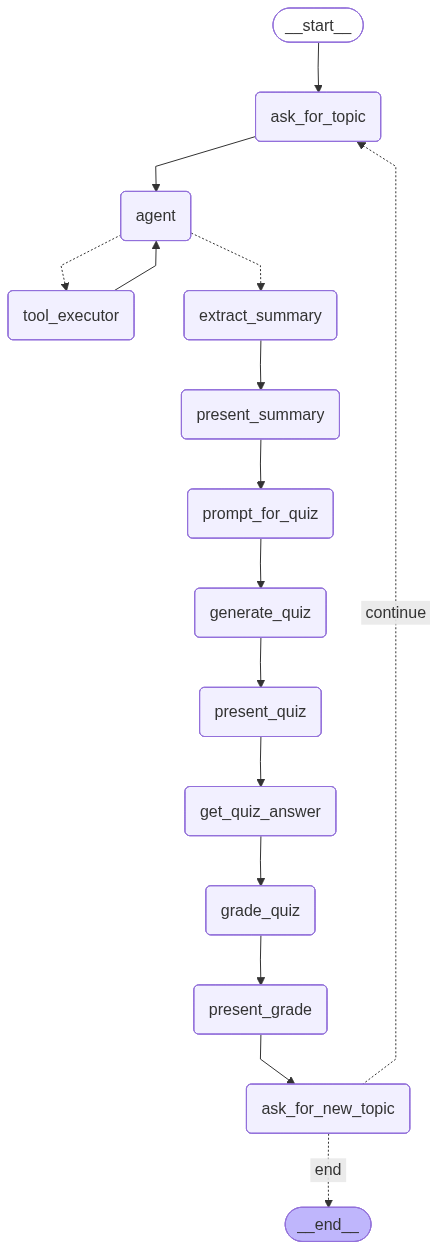

In [18]:
workflow = StateGraph(State)

# nodes
workflow.add_node("ask_for_topic", ask_for_topic)
workflow.add_node("agent", agent)
workflow.add_node("tool_executor", tool_executor)
workflow.add_node("extract_summary", extract_summary)
workflow.add_node("present_summary", present_summary)
workflow.add_node("prompt_for_quiz", prompt_for_quiz)
workflow.add_node("generate_quiz", generate_quiz)
workflow.add_node("present_quiz", present_quiz)
workflow.add_node("get_quiz_answer", get_quiz_answer)
workflow.add_node("grade_quiz", grade_quiz)
workflow.add_node("present_grade", present_grade)
workflow.add_node("ask_for_new_topic", ask_for_new_topic)

workflow.add_edge(START, "ask_for_topic")
workflow.add_edge("ask_for_topic", "agent")
workflow.add_conditional_edges(
    "agent",
    should_call_tool,
    {
        "tool_executor": "tool_executor",
        "extract_summary": "extract_summary",
    },
)
workflow.add_edge("tool_executor", "agent")
workflow.add_edge("extract_summary", "present_summary")
workflow.add_edge("present_summary", "prompt_for_quiz")
workflow.add_edge("prompt_for_quiz", "generate_quiz")
workflow.add_edge("generate_quiz", "present_quiz")
workflow.add_edge("present_quiz", "get_quiz_answer")
workflow.add_edge("get_quiz_answer", "grade_quiz")
workflow.add_edge("grade_quiz", "present_grade")
workflow.add_edge("present_grade", "ask_for_new_topic")
workflow.add_conditional_edges(
    "ask_for_new_topic",
    should_continue,
    {
        "continue": "ask_for_topic",
        "end": END,
    },
)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
display(Image(app.get_graph().draw_mermaid_png()))

In [19]:
config = RunnableConfig(recursion_limit=2000, configurable={"thread_id": "1"})


initial_state = {"topic": "", "summary": "", "quiz": "", "quiz_ground_truth": "", "answer": "", "grade": "", "messages": []}

app.invoke(
    initial_state,
    config,
)

Thinking...
Searching for information on Cancer...
---- Tavily ---- {'query': 'Cancer', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.mayoclinic.org/diseases-conditions/cancer/symptoms-causes/syc-20370588', 'title': 'Cancer - Symptoms and causes - Mayo Clinic', 'content': 'Cancer refers to any one of a large number of diseases characterized by the development of abnormal cells that divide uncontrollably and have the ability to infiltrate and destroy normal body tissue. Cancer often has the ability to spread throughout your body.\n\nCancer is the second-leading cause of death in the world. But survival rates are improving for many types of cancer, thanks to improvements in cancer screening, treatment and prevention.\n\n### Products & Services [...] Cancer is caused by changes (mutations) to the DNA within cells. The DNA inside a cell is packaged into a large number of individual genes, each of which contains a set of instructions telling the

{'messages': [SystemMessage(content='You are a HealthBot. Your task is to research a given health topic using the available tools and then provide a 3-4 paragraph summary of the results in a patient-friendly way. Do not use any other knowledge or data sources.', additional_kwargs={}, response_metadata={}, id='dcadf049-5ecd-4f33-8f19-b1b9849f912b'),
  HumanMessage(content='Cancer', additional_kwargs={}, response_metadata={}, id='72ec0db2-f3d7-4c65-81bf-d3eac2a375cd'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_j1LABBlnLcCBmvMSJqiXUnnZ', 'function': {'arguments': '{"query":"Cancer","search_depth":"advanced"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125', 'service_tier': 'default'}, id='run--0ee9b224-200f-4c85-a90b-3e147def2721-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Cancer', 'search_depth': 'advanced'}, 'id': 'call_j1LABBlnLcCBmvMSJqiXUnnZ